## Import libraries and define functions

In [1]:
# PATH = "C:/Users/amd/OneDrive - National University of Singapore/SleepData"
# EDF_FILE_PATH = "C:/Users/amd/OneDrive - National University of Singapore/SleepData/szu_hospital/PSG/2024-6-20jiangyifan.edf"
# PSG_FILE_PATH = "C:/Users/amd/OneDrive - National University of Singapore/SleepData/szu_hospital/PSG/2024-6-20jiangyifan.edf"
# XML_FILE_PATH = "psg/20240620江逸凡.edf.XML"
# SAVE_PATH = "C:/Users/amd/OneDrive - National University of Singapore/SleepData/szu_hospital/PSG/merged_2024-6-20jiangyifan.edf.pkl"
# print(PSG_FILE_PATH)

In [5]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from cw_radar import *
from psg import *
import importlib
import constants
importlib.reload(constants)
from constants import PSG_FILE_PATH, XML_FILE_PATH, SAVE_PATH

def one_hot_encode(df_psg, df_xml, encode_type='stage'):
    """
    One-hot encode events or sleep stages and integrate into the PSG DataFrame.

    Parameters:
    - df_psg: DataFrame containing the PSG data.
    - df_xml: XMLProcessor object containing event and sleep stage data.
    - encode_type: str, either 'stage' or 'event' to specify what to encode.

    Returns:
    - DataFrame: PSG DataFrame with one-hot encoded columns integrated.
    """
    if encode_type == 'stage':
        df_data = df_xml.sleep_stages
        time_window = 30
        unique_items = df_data['Sleep Stage'].unique()
        time_column = 'Start Time'
    elif encode_type == 'event':
        df_data = df_xml.events
        time_window = 1
        unique_items = df_data['Name'].unique()
        time_column = 'Start'
    else:
        raise ValueError("Invalid encode_type. Must be 'stage' or 'event'.")

    # Create an empty DataFrame with the same index as df_psg
    one_hot_df = pd.DataFrame(index=df_psg.index)
    time_window = timedelta(seconds=time_window)
    
    # Create one-hot encoded columns for each unique item
    for item in unique_items:
        one_hot_df[item] = 0

    # Fill in the one-hot encoded values based on times
    for _, row in df_data.iterrows():
        start_time = row[time_column]
        
        if encode_type == 'stage':
            end_time = start_time + time_window
            item = row['Sleep Stage']
            mask = (df_psg.index >= start_time) & (df_psg.index < end_time)

        else:  # encode_type == 'event'
            end_time = row['End']
            item = row['Name']
            mask = (df_psg.index >= start_time - time_window) & (df_psg.index < end_time + time_window) # label window: 1s before and after the event
        
        one_hot_df.loc[mask, item] = 1

    return one_hot_df

def integrate(df_psg, df_xml):
    # One-hot encode events and sleep stages
    events_one_hot = one_hot_encode(df_psg, df_xml, encode_type='event')
    stages_one_hot = one_hot_encode(df_psg, df_xml, encode_type='stage')

    # Integrate the one-hot encoded DataFrames into the PSG DataFrame
    return pd.concat([df_psg, stages_one_hot, events_one_hot], axis=1)


/opt/data/private/ZhouWenren/SleepLab/psg/2024-6-20jiangyifan.edf


## Load PSG data

In [6]:
psg_file_path = PSG_FILE_PATH
# psg_file_path = r"C:\Users\amd\OneDrive - National University of Singapore\SleepData\szu_hospital\PSG\2024-6-20jiangyifan.edf"
psg_processor = PSGDataProcessor(psg_file_path)
psg_processor.load_data()

Extracting EDF parameters from /opt/data/private/ZhouWenren/SleepLab/psg/2024-6-20jiangyifan.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 29025279  =      0.000 ... 28344.999 secs...


/opt/data/private/ZhouWenren/SleepLab/psg/psg_data_extraction.py:41: RuntimeWarning: Physical range is not defined in following channels:
Thor, Abdo, Sum
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)
/opt/data/private/ZhouWenren/SleepLab/psg/psg_data_extraction.py:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)
/opt/data/private/ZhouWenren/SleepLab/psg/psg_data_extraction.py:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)


Sampling Rate: 1024.0
Channel Names: ['E1-M2', 'E2-M2', 'Chin 1-Chin 2', 'F4-M1', 'C4-M1', 'O2-M1', 'F3-M2', 'C3-M2', 'O1-M2', 'ECG', 'Pressure', 'Therm', 'Thor', 'Abdo', 'Sum', 'Mic', 'Position', 'SpO2', 'Ox Status', 'Leg/L', 'Leg/R', 'Pulse', 'Pleth']
Start Datetime: 2024-06-20 22:02:34
End Datetime: 2024-06-21 05:54:58.999023


In [ ]:
print(len(psg_processor.data['ECG']))
print(psg_processor.data['ECG'][0]) # ECG data
print(len(psg_processor.data['ECG'][0][0]))
print(psg_processor.data['ECG'][1]) # ECG timestamps
print(len(psg_processor.data['ECG'][1]))

### Extract segments of ECG data

In [ ]:
# Specify the start and stop times in seconds
tmin, tmax = 10, 20  # Extract data between 10 and 20 seconds
psg_time_segment = psg_processor.extract_data_by_range(tmin, tmax)
print(psg_time_segment)

In [ ]:
# Extract data between two timestamps
start_datetime = datetime(2024, 6, 20, 22, 10, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 11, 33)  # Replace with your actual end datetime
data_types = ['ECG', 'Thor']  # Replace with your actual data types

print(f"Start Timestamp: {start_datetime}, End Timestamp: {end_datetime}")  # Print the start and end timestamps of the extracted data
psg_date_segment = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, data_types)
print(psg_date_segment)


## Load XML data

In [7]:
xml_file_path = XML_FILE_PATH
start_datetime_str = "2024-06-20 22:02:34"
xml_processor = XMLProcessor(xml_file_path, start_datetime_str)

xml_processor.load()

                      Name  Actual Start (sec)  Duration  \
0              Mixed Apnea               91.67      0.24   
1     Limb Movement (Left)              336.65      2.15   
2    Limb Movement (Right)              336.61      2.24   
3     Limb Movement (Left)              499.71      2.27   
4    Limb Movement (Right)              500.37      1.69   
..                     ...                 ...       ...   
601            PLM (Right)            27023.70      2.02   
602  Limb Movement (Right)            27026.70      2.60   
603  Limb Movement (Right)            27099.80      2.15   
604  Limb Movement (Right)            27234.00      1.94   
605  Limb Movement (Right)            27337.50      1.69   

                      Start                     End    Input  
0   2024-06-20 22:04:05.670 2024-06-20 22:04:05.910  Airflow  
1   2024-06-20 22:08:10.650 2024-06-20 22:08:12.800    Leg/L  
2   2024-06-20 22:08:10.610 2024-06-20 22:08:12.850    Leg/R  
3   2024-06-20 22:10:53.710

In [ ]:
xml_processor.sleep_stages

In [ ]:
xml_processor.events

### Unique events and sleep stages

In [ ]:
unique_event_names = xml_processor.events['Name'].unique()
print(unique_event_names)

unique_sleep_stages = xml_processor.sleep_stages['Sleep Stage'].unique()
print(unique_sleep_stages)

### Filter by event type

In [ ]:
# Assuming xml_processor.df_events is your DataFrame
xml_filtered_by_type = xml_processor.events[xml_processor.events['Name'].str.contains('limb', case=False)]
xml_filtered_by_type

### Events filtered by time range

In [ ]:
# Filter rows where 'timestamp' is within the specified range
start_datetime = datetime(2024, 6, 20, 22, 10, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 11, 33)  # Replace with your actual end datetime
xml_filtered_by_type = xml_filtered_by_type[(xml_filtered_by_type['Start'] >= start_datetime) & (xml_filtered_by_type['Start'] <= end_datetime)]
xml_filtered_by_type

In [ ]:
print(psg_date_segment)
print(xml_filtered_by_type)

### Events sorted by duration

In [ ]:
durations = xml_processor.events['Duration']
print(durations.describe())
xml_sorted_by_duration = xml_processor.events.sort_values(by='Duration', ascending=False)
print(xml_sorted_by_duration)

## Merge the two dataframes: PSG(bio signals) and XML(event labels)

### Load PSG and XML data

In [ ]:
# psg_file_path = r"C:\Users\amd\OneDrive - National University of Singapore\SleepData\szu_hospital\PSG\2024-6-20jiangyifan.edf"
psg_file_path = PSG_FILE_PATH
psg_processor = PSGDataProcessor(psg_file_path)
psg_processor.load_data()

xml_file_path = XML_FILE_PATH
start_datetime_str = "2024-06-20 22:02:34"
xml_processor = XMLProcessor(xml_file_path, start_datetime_str)
xml_processor.load()

df_sleep_events = xml_processor.events
print(psg_processor.start_datetime)
print(xml_processor.start_datetime)

### Extract the time range of interest

In [ ]:
print(f"Start Timestamp: {psg_processor.start_datetime}, End Timestamp: {psg_processor.end_datetime}")

# Start Timestamp: 2024-06-20 22:02:34, End Timestamp: 2024-06-21 05:54:58.999023
start_datetime = datetime(2024, 6, 20, 22, 2, 34) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 21, 5, 54, 58)  # Replace with your actual end datetime
# # Extract data between two timestamps
# start_datetime = datetime(2024, 6, 20, 22, 10, 33) # Replace with your actual start datetime
# end_datetime = datetime(2024, 6, 20, 22, 11, 33)  # Replace with your actual end datetime
data_types = ['ECG', 'Thor']  # Replace with your actual data types

print(f"Start Timestamp: {start_datetime}, End Timestamp: {end_datetime}")  # Print the start and end timestamps of the extracted data
psg_date_segment = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, data_types)
print(psg_date_segment)

In [ ]:
# Specify the start and stop times in seconds
tmin, tmax = 0, 60  # Extract data between 10 and 20 seconds
data_types = ['ECG', 'Thor']  # Replace with your actual data types

start_dt, end_dt, psg_time_segment = psg_processor.extract_data_by_range(tmin, tmax)
psg_time_segment = psg_time_segment[data_types]
print(f"Start time: {start_dt}, End time: {end_dt}")
print(psg_time_segment)

### Merge

In [ ]:
# Assuming df_psg is your processed PSG DataFrame
df_psg = psg_date_segment
# df_psg = psg_time_segment

# One-hot encode events and sleep stages
# events_one_hot_e = one_hot_encode(df_psg, xml_processor, 'event')
# events_one_hot_s = one_hot_encode(df_psg, xml_processor, 'stage')

merged_df = integrate(df_psg, xml_processor)
print(merged_df.head())

### Examine the correctness of the one-hot encoding

In [ ]:
s = xml_processor.sleep_stages
s_filtered = s[(s['Start Time'] >= start_datetime) & (s['Start Time'] <= end_datetime)]

# Filter rows within the time range
t_filtered = merged_df.loc[start_datetime:end_datetime]

# Extract the specified columns from filtered_temp
wake1 = t_filtered[t_filtered['Wakefulness (W)'] == 1]
print(wake1.head().index[0])
wake2 = s_filtered[s_filtered['Sleep Stage'] == 'Wakefulness (W)']
print(wake2)

stage1 = t_filtered[t_filtered['NREM Sleep Stage 1 (N1)'] == 1]
print(stage1.head().index[0])
stage2 = s_filtered[s_filtered['Sleep Stage'] == 'NREM Sleep Stage 1 (N1)']
print(stage2)



### Save the complete(merged) DataFrame to a CSV/Pickle file

In [ ]:
# Define the file path and get the directory path and filename
# psg_file_path = "/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf"
psg_file_path = PSG_FILE_PATH
dir_path, filename = os.path.split(psg_file_path)
modified_filename = 'merged_' + filename

# # Save as CSV file for portability
# save_path = os.path.join(dir_path, modified_filename + '.csv')
# merged_df.to_csv(save_path, index=False)  # Set index=False if you don't want to save the index
# print(f"CSV file saved at: {save_path}")

# Save as Pickle file for efficiency and compactness
save_path = os.path.join(dir_path, modified_filename + '.pkl')
merged_df.to_pickle(save_path)
print(f"Pickle file saved at: {save_path}")

### Load the merged DataFrame

In [ ]:
# Specify the path to the pickle file
save_path = SAVE_PATH
pickle_path = save_path # '/path/to/your/filename.pkl'
psg_date_segment = pd.read_pickle(pickle_path)

# Display the first few rows of the DataFrame
print(psg_date_segment.head())

## ERA(Event-related Analysis): Sleep Stages

### The Dataset

In [ ]:
df_sleep_stages = xml_processor.sleep_stages
df_sleep_stages


In [ ]:
codes = xml_processor.sleep_stages['Sleep Stage Code'].values
print(np.unique(codes))

stages = xml_processor.sleep_stages['Sleep Stage'].values
print(np.unique(stages))

#### Prepare the data (Time window)

In [ ]:
print(psg_processor.start_datetime)
print(psg_processor.end_datetime)

In [ ]:
# start_datetime = datetime(2024, 6, 20, 22, 40, 33) # Replace with your actual start datetime
# end_datetime = datetime(2024, 6, 20, 23, 10, 33)  # Replace with your actual end datetime
start_datetime = datetime(2024, 6, 20, 22, 40, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 23, 00, 33)  # Replace with your actual end datetime

start_time = start_datetime
end_time = end_datetime

filtered_df = psg_date_segment.loc[start_time:end_time]
df_subset = filtered_df[['ECG', 'Thor']]
print(df_subset.head())

#### Prepare the data (add columns)

In [ ]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        # df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        # df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        # df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_with_sleep_stage = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_with_sleep_stage)
print(df_subset_with_sleep_stage['Stage Code'].value_counts())

In [ ]:
# psg_processor.signals_diagram(df_subset_with_sleep_stage)

### Find Events (Auto)

#### Process and plot the events

In [ ]:
# Define events based on sleep stages
# df_subset_with_sleep_stage['ECG'] = df_subset_with_sleep_stage['ECG'] *100000
# df_subset_with_sleep_stage['Thor'] = df_subset_with_sleep_stage['Thor'] *100000
events1 = nk.events_find(df_subset_with_sleep_stage['Stage Code'], threshold=0, threshold_keep='below')
print(events1)
plot = nk.events_plot(events1, df_subset_with_sleep_stage)


In [ ]:
events2 = nk.events_find(df_subset_with_sleep_stage['Stage Code'], threshold=0, threshold_keep='above')
print(events2)
plot = nk.events_plot(events2, df_subset_with_sleep_stage)


In [ ]:
print(events1)
print(events2)

In [ ]:

# Combine the arrays
combined_onset = np.concatenate((events1['onset'], events2['onset']))
combined_duration = np.concatenate((events1['duration'], events2['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


In [ ]:
plot = nk.events_plot(merged_events, df_subset_with_sleep_stage)

#### Plot RSP diagram (trial)

In [ ]:
psg_processor.start_datetime

In [ ]:
extracted_types = ['Thor']
start_datetime = datetime(2024, 6, 20, 22, 58, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 59, 33)  # Replace with your actual end datetime
extracted_data = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, extracted_types)
rsp_signals, rsp_info = psg_processor.rsp_diagram(extracted_data['Thor'])


#### Process the Signals

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(ecg=df_subset_with_sleep_stage["ECG"], 
                                  rsp=df_subset_with_sleep_stage["Thor"],
                                  keep=df_subset_with_sleep_stage["Stage Code"],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]].plot(subplots=True)

In [ ]:
x = df_subset_with_sleep_stage['Stage Code'].values

plt.figure(figsize=(6, 3))  # Set the figure size for better readability
plt.plot(x, marker='o', linestyle='-', color='b')  # Plot x with markers and lines
plt.show()  

#### Create Epochs

In [ ]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)

In [ ]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

In [ ]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)  

#### Interval Analysis

In [ ]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]])

In [ ]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

In [ ]:
# Analyze
nk.ecg_intervalrelated(epochs)

In [ ]:
nk.rsp_intervalrelated(epochs)

#### Plot ECG and RSP signals

In [ ]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['ECG'], label='ECG')  # Plot the ECG column
plt.title('ECG Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('ECG Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['Thor'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

#### Feature Extraction (Auto)

In [ ]:
# df = nk.bio_analyze(epochs, sampling_rate=1024)
# df

#### Feature Extraction (Manual)

In [ ]:
df_temp = {}  # Initialize an empty dict to store the results
         
# Iterate through epochs index and data
for epoch_index, epoch in epochs.items():
    df_temp[epoch_index] = {}  # Initialize an empty dict inside of it
                            

    # Note: We will use the 100th value (corresponding to the event onset, 0s) as the baseline

    # ECG ====
    ecg_baseline = epoch["ECG_Rate"].values[100]  # Baseline
    ecg_mean = epoch["ECG_Rate"][0:4].mean()  # Mean heart rate in the 0-4 seconds
    # Store ECG in df_temp
    df_temp[epoch_index]["ECG_Rate_Mean"] = ecg_mean - ecg_baseline  # Correct for baseline

    # RSP ====
    rsp_baseline = epoch["RSP_Rate"].values[100]  # Baseline
    rsp_rate = epoch["RSP_Rate"][0:6].mean()  # Longer window for RSP that has a slower dynamic
    # Store RSP in df_temp
    df_temp[epoch_index]["RSP_Rate_Mean"] = rsp_rate - rsp_baseline  # Correct for baseline

df_temp = pd.DataFrame.from_dict(df_temp, orient="index")  # Convert to a dataframe
df_temp  # Print DataFrame

#### Plot Event-Related Features

In [ ]:
df_reset = df_temp.reset_index()
print(df_reset)

In [ ]:
import seaborn as sns
sns.boxplot(x="index", y="ECG_Rate_Mean", data=df_reset)

In [ ]:
import seaborn as sns
sns.boxplot(x="index", y="RSP_Rate_Mean", data=df_reset)

### Find Events (Manual)

In [ ]:
df_sleep_stages['Duration'] = 30
df_sleep_stages

#### Prepare the data (add columns)

In [ ]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_sleep = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_sleep)
print(df_subset_sleep['Stage Code'].value_counts())

#### Create Events

In [ ]:
def extract_sleep_stages(df_sleep_stages, start_datetime, end_datetime):
    
    # Calculate 'End Time' assuming each stage lasts 30 seconds
    df_sleep_stages['End Time'] = df_sleep_stages['Start Time'] + pd.Timedelta(seconds=30)
    df_subset = df_sleep_stages[(df_sleep_stages['Start Time'] >= start_datetime) & (df_sleep_stages['End Time'] <= end_datetime)]
    
    return df_subset



In [ ]:
start_datetime = datetime(2024, 6, 20, 22, 40, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 23, 10, 33)  # Replace with your actual end datetime

df_subset_sleep = extract_sleep_stages(df_sleep_stages, start_datetime, end_datetime)
df_subset_sleep.head()

In [ ]:
df_sleep_stages_dur = df_subset_sleep
event_onsets = df_sleep_stages_dur['Time (seconds)'].values
event_durations = df_sleep_stages_dur['Duration'].values
event_conditions = df_sleep_stages_dur['Sleep Stage'].values

events = nk.events_create(event_onsets = event_onsets,
                          event_durations = event_durations,
                          event_conditions= event_conditions)

print(events)


In [ ]:
print(df_subset)
print(df_subset_sleep['Sleep Stage Code'].value_counts())

#### Plot the events

In [ ]:
events

In [ ]:

# Plot the location of event with the signals
plot = nk.events_plot(events, df_subset)

## IRA(Interval-related Analysis)

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(ecg=df_subset_with_sleep_stage["ECG"], 
                                  rsp=df_subset_with_sleep_stage["Thor"],
                                  keep=df_subset_with_sleep_stage["Stage Code"],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]].plot(subplots=True)

In [ ]:
data, info = nk.ecg_process(df_subset_with_sleep_stage["ECG"], sampling_rate=1024)
nk.ecg_intervalrelated(data, sampling_rate=1024)


In [ ]:
# epochs = nk.epochs_create(df, events=[0, 15000], sampling_rate=100, epochs_end=150)

# # Half the data
# epochs = nk.epochs_create(ecg_signals, 
#                           events=[0, 15000], 
#                           sampling_rate=100, 
#                           epochs_start=0, 
#                           epochs_end=150)

# nk.ecg_intervalrelated(epochs)

## ERA(Event-related Analysis): Events

In [ ]:
# Check which columns of the df_suset have non-zero values within the given time range and return the column names
def check_non_zero_columns(df, start_datetime, end_datetime):
    # Filter rows within the time range
    df = df.loc[start_datetime:end_datetime]
    
    # Define the list of columns to extract
    columns = df.columns
    
    # Check which columns have non-zero values
    non_zero_columns = df.columns[(df != 0).any()]
    
    return non_zero_columns

In [ ]:
events = xml_processor.events['Name'].values
print(np.unique(events))

### Limb Movement

In [ ]:
event_type = 'Limb Movement (Left)'

#### Prepare the data (Time window)

In [ ]:
# start_datetime = datetime(2024, 6, 20, 22, 40, 33) # Replace with your actual start datetime
# end_datetime = datetime(2024, 6, 20, 23, 10, 33)  # Replace with your actual end datetime
start_datetime = datetime(2024, 6, 20, 22, 8, 0) # 2024-06-20 22:08:00
end_datetime = datetime(2024, 6, 20, 22, 11, 0) # 2024-06-20 22:11:00

start_time = start_datetime
end_time = end_datetime

filtered_df = psg_date_segment.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Thor', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())

#### Find Events (Auto)

#### Process and plot the events

In [ ]:
# Example usage: 
non_zero_columns = check_non_zero_columns(psg_date_segment, start_datetime, end_datetime)
print(non_zero_columns)

In [ ]:
# Define events for specific event types (label value above threshold: 0)
# , df_subset['Limb Movement (Right)']
events3 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='above')
print(events3)
plot = nk.events_plot(events3, df_subset[['ECG', 'Thor']])


In [ ]:
events4 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='below')
print(events4)
plot = nk.events_plot(events4, df_subset[['ECG', 'Thor']])

In [ ]:
# Combine the arrays
combined_onset = np.concatenate((events3['onset'], events4['onset']))
combined_duration = np.concatenate((events3['duration'], events4['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


In [ ]:
plot = nk.events_plot(merged_events, df_subset[['ECG', 'Thor']])

#### Process the Signals

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(ecg=df_subset["ECG"], 
                                  rsp=df_subset["Thor"],
                                  keep=df_subset[event_type],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", event_type]].plot(subplots=True)

#### Create Epochs

In [ ]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)

In [ ]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

In [ ]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)  

#### Interval Analysis

In [ ]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", event_type]])

In [ ]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

In [ ]:
epochs['1'] # less than 10s (9.65s)

In [ ]:
epochs['3'] # greater than 10s (158s)

In [ ]:
epochs['4'] # less than 10s (4.3s)

In [ ]:
# Analyze
nk.ecg_intervalrelated(epochs['3'])

In [ ]:
nk.rsp_intervalrelated(epochs['3'])

### Hypopnea

In [ ]:
event_type = 'Hypopnea'

#### The Dataset

In [ ]:
pnea_df = df_sleep_events[df_sleep_events['Name'].str.contains('pnea')]
pnea_df

#### Prepare the data (Time window)

In [ ]:
# 2024-06-20 22:14:58.200	2024-06-20 22:15:10.130
start_datetime = datetime(2024, 6, 20, 22, 13, 00)
end_datetime = datetime(2024, 6, 20, 22, 16, 00) 

start_time = start_datetime
end_time = end_datetime

filtered_df = psg_date_segment.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Thor', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())

#### Prepare the data (add columns)

#### Find Events (Auto)

#### Process and plot the events

In [ ]:
# Example usage: 
non_zero_columns = check_non_zero_columns(psg_date_segment, start_datetime, end_datetime)
print(non_zero_columns)

In [ ]:
# Define events for specific event types (label value above threshold: 0)
# , df_subset['Limb Movement (Right)']
events3 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='above')
print(events3)
plot = nk.events_plot(events3, df_subset[['ECG', 'Thor']])


In [ ]:
events4 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='below')
print(events4)
plot = nk.events_plot(events4, df_subset[['ECG', 'Thor']])

In [ ]:
# Combine the arrays
combined_onset = np.concatenate((events3['onset'], events4['onset']))
combined_duration = np.concatenate((events3['duration'], events4['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


In [ ]:
plot = nk.events_plot(merged_events, df_subset[['ECG', 'Thor']])

#### Process the Signals

In [ ]:
df_subset["ECG"].describe()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['ECG'], label='ECG')  # Plot the ECG column
plt.title('ECG Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('ECG Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['Thor'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(
                                  ecg=df_subset["ECG"],
                                  rsp=df_subset["Thor"],
                                  keep=df_subset[event_type],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", event_type]].plot(subplots=True)

#### Create Epochs

In [ ]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)

In [ ]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

In [ ]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)


#### Interval Analysis

In [ ]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", event_type]])

In [ ]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

In [ ]:
nk.rsp_intervalrelated(epochs['1'])

In [ ]:
nk.rsp_intervalrelated(epochs['2'])

In [ ]:
nk.rsp_intervalrelated(epochs['4'])

In [ ]:
nk.rsp_intervalrelated(epochs['5'])

### Central Apnea

In [ ]:
event_type = 'Central Apnea'

#### The Dataset

In [ ]:
pnea_df = df_sleep_events[df_sleep_events['Name'].str.contains(event_type)]
pnea_df

#### Prepare the data (Time window)

In [ ]:
# 2024-06-21 03:33:36.600	2024-06-21 03:33:54.830
start_datetime = datetime(2024, 6, 21, 3, 33, 00)
end_datetime = datetime(2024, 6, 21, 3, 35, 00) 

start_time = start_datetime
end_time = end_datetime

filtered_df = psg_date_segment.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Thor', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())

#### Find Events (Auto)

#### Process and plot the events

In [ ]:
# Example usage: 
non_zero_columns = check_non_zero_columns(psg_date_segment, start_datetime, end_datetime)
print(non_zero_columns)

In [ ]:
# Define events for specific event types (label value above threshold: 0)
# , df_subset['Limb Movement (Right)']
events3 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='above')
print(events3)
plot = nk.events_plot(events3, df_subset[['ECG', 'Thor']])


In [ ]:
events4 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='below')
print(events4)
plot = nk.events_plot(events4, df_subset[['ECG', 'Thor']])

In [ ]:
# Combine the arrays
combined_onset = np.concatenate((events3['onset'], events4['onset']))
combined_duration = np.concatenate((events3['duration'], events4['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


In [ ]:
plot = nk.events_plot(merged_events, df_subset[['ECG', 'Thor']])

#### Process the Signals

In [ ]:
df_subset["ECG"].describe()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['ECG'], label='ECG')  # Plot the ECG column
plt.title('ECG Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('ECG Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['Thor'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
# Process the signal
data_clean, info_rsp = nk.bio_process(
                                  ecg=df_subset["ECG"],
                                  rsp=df_subset["Thor"],
                                  keep=df_subset[event_type],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", event_type]].plot(subplots=True)

#### Create Epochs

In [ ]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)

In [ ]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

In [ ]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)


#### Interval Analysis

In [ ]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", event_type]])

In [ ]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

In [ ]:
nk.ecg_intervalrelated(epochs["1"])

In [ ]:
nk.rsp_intervalrelated(epochs["1"])

In [ ]:
pnea_df

In [ ]:
# 2024-06-21 03:33:36.600	2024-06-21 03:33:54.830
start_datetime = datetime(2024, 6, 21, 3, 32, 00)
end_datetime = datetime(2024, 6, 21, 3, 34, 00) 

start_time = start_datetime
end_time = end_datetime

filtered_df2 = psg_date_segment.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Thor', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset2 = filtered_df2.drop(columns=columns_to_drop)
print(df_subset2.head())

plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset2['Thor'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

### Obstructive Apnea

In [ ]:
event_type = 'Obstructive Apnea'

#### The Dataset

In [ ]:
pnea_df = df_sleep_events[df_sleep_events['Name'].str.contains(event_type)]
pnea_df

#### Prepare the data (Time window)

In [ ]:
# 2024-06-21 03:33:36.600	2024-06-21 03:33:54.830
start_datetime = datetime(2024, 6, 21, 4, 10, 00)
end_datetime = datetime(2024, 6, 21, 4, 11, 30) 

start_time = start_datetime
end_time = end_datetime

filtered_df = psg_date_segment.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Thor', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())

#### Find Events (Auto)

#### Process and plot the events

In [ ]:
# Example usage: 
non_zero_columns = check_non_zero_columns(psg_date_segment, start_datetime, end_datetime)
print(non_zero_columns)

In [ ]:
# Define events for specific event types (label value above threshold: 0)
# , df_subset['Limb Movement (Right)']
events3 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='above')
print(events3)
plot = nk.events_plot(events3, df_subset[['ECG', 'Thor']])


In [ ]:
events4 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='below')
print(events4)
plot = nk.events_plot(events4, df_subset[['ECG', 'Thor']])

In [ ]:
# Combine the arrays
combined_onset = np.concatenate((events3['onset'], events4['onset']))
combined_duration = np.concatenate((events3['duration'], events4['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


In [ ]:
plot = nk.events_plot(merged_events, df_subset[['ECG', 'Thor']])

#### Process the Signals

In [ ]:
df_subset["ECG"].describe()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['ECG'], label='ECG')  # Plot the ECG column
plt.title('ECG Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('ECG Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['Thor'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
# Process the signal
data_clean, info_rsp = nk.bio_process(
                                  ecg=df_subset["ECG"],
                                  rsp=df_subset["Thor"],
                                  keep=df_subset[event_type],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", event_type]].plot(subplots=True)

#### Create Epochs

In [ ]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-10, epochs_end=10)

In [ ]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

In [ ]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)


#### Interval Analysis

In [ ]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", event_type]])

In [ ]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

In [ ]:
nk.ecg_intervalrelated(epochs)

In [ ]:
nk.rsp_intervalrelated(epochs)

In [ ]:
pnea_df

In [ ]:
# 2024-06-21 03:33:36.600	2024-06-21 03:33:54.830
start_datetime = datetime(2024, 6, 21, 4, 10, 00)
end_datetime = datetime(2024, 6, 21, 4, 11, 30) 

start_time = start_datetime
end_time = end_datetime

filtered_df2 = psg_date_segment.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Thor', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset2 = filtered_df2.drop(columns=columns_to_drop)
print(df_subset2.head())

plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset2['Thor'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

# Test 1: Create 3D dataframe

In [ ]:
events = xml_processor.events['Name'].values
unique_events = np.unique(events)
unique_events

In [ ]:
print(psg_processor.start_datetime)
print(psg_processor.end_datetime)

In [ ]:
event_type = 'Obstructive Apnea'
event_df = df_sleep_events[df_sleep_events['Name'].str.contains(event_type)]
event_df

# 2024-06-21 03:33:36.600	2024-06-21 03:33:54.830
start_datetime = datetime(2024, 6, 20, 22, 2, 35)
end_datetime = datetime(2024, 6, 21, 5, 54, 58) 

start_time = start_datetime
end_time = end_datetime

filtered_df = psg_date_segment.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Thor', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())


In [ ]:
df_subset.columns


In [ ]:
# Initialize the dictionary to hold the 3-level structure
structured_data = {}

# Ensure the 'Start' and 'End' times in xml_processor.events are in datetime format
# Assuming 'Start' and 'End' are already in datetime or timedelta format
events_df = xml_processor.events

# Iterate over each unique event type
for event_type in events_df['Name'].unique():
    # Filter the events of this type
    event_occurrences = events_df[events_df['Name'] == event_type]
    
    # Initialize a list to hold all occurrences for this event type
    occurrences_list = []
    
    # Iterate over each occurrence of this event type
    for _, event_row in event_occurrences.iterrows():
        start_time = event_row['Start']
        end_time = event_row['End']
        
        # Extract the relevant rows from df_subset for ECG and Thor within the time range
        relevant_data = df_subset[(df_subset.index >= start_time) & (df_subset.index <= end_time)][['ECG', 'Thor']]
        
        # Add the relevant data for this occurrence
        occurrences_list.append({
            'Start': start_time,
            'End': end_time,
            'ECG': relevant_data['ECG'].values,
            'Thor': relevant_data['Thor'].values,
            'Time': relevant_data.index
        })
    
    # Store the list of occurrences for this event type
    structured_data[event_type] = occurrences_list

# Example: Access data for a specific event type
# structured_data['Mixed Apnea'] will give you the occurrences and corresponding ECG/Thor data


In [ ]:
def plot_event_data(event_type):
    # Check if the event_type exists in the structured_data
    if event_type not in structured_data:
        print(f"Event type '{event_type}' not found in structured data.")
        return
    
    # Retrieve all occurrences for the given event type
    event_data = structured_data[event_type]
    
    # Iterate over each occurrence and plot ECG and Thor data
    for i, occurrence in enumerate(event_data):
        # Create subplots for ECG and Thor
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4))  # 2 rows, 1 column

        # Plot ECG
        ax1.plot(occurrence['Time'], occurrence['ECG'], label='ECG')
        ax1.set_title(f'{event_type} - ECG (# {i + 1})')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('ECG Value')
        ax1.legend()

        # Plot Thor
        ax2.plot(occurrence['Time'], occurrence['Thor'], label='Thor')
        ax2.set_title(f'{event_type} - Thor (# {i + 1})')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Thor Value')
        ax2.legend()

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()  # Display the plot

#### Central Apnea

In [ ]:
# Example usage:
event_type_name = "Central Apnea"  # Replace with the event type you want to plot
plot_event_data(event_type_name)


#### Obstructive Apnea

In [ ]:
# Example usage:
event_type_name = "Obstructive Apnea"  # Replace with the event type you want to plot
plot_event_data(event_type_name)

#### Hypopnea

In [ ]:
# Example usage:
event_type_name = "Hypopnea"  # Replace with the event type you want to plot
plot_event_data(event_type_name)


In [ ]:
psg_date_segment

# Test 2: Identify events at whole-night scale

In [ ]:
df_sleep_stages = xml_processor.sleep_stages

start_datetime = psg_processor.start_datetime
end_datetime = psg_processor.end_datetime

filtered_df = psg_date_segment.loc[start_datetime:end_datetime]
df_subset = filtered_df[['ECG', 'Thor']]
print(df_subset.head())

In [ ]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        # df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        # df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        # df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_with_sleep_stage = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_with_sleep_stage)
print(df_subset_with_sleep_stage['Stage Code'].value_counts())

In [ ]:
df_subset_with_sleep_stage = df_subset_with_sleep_stage.dropna(subset=['Stage Code'])


In [ ]:
events1 = nk.events_find(df_subset_with_sleep_stage['Stage Code'], threshold=0, threshold_keep='below')
events2 = nk.events_find(df_subset_with_sleep_stage['Stage Code'], threshold=0, threshold_keep='above')


# Combine the arrays
combined_onset = np.concatenate((events1['onset'], events2['onset']))
combined_duration = np.concatenate((events1['duration'], events2['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(ecg=df_subset_with_sleep_stage["ECG"], 
                                  rsp=df_subset_with_sleep_stage["Thor"],
                                  keep=df_subset_with_sleep_stage["Stage Code"],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]].plot(subplots=True)

In [ ]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]])


In [ ]:
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')


In [ ]:
nk.rsp_intervalrelated(epochs)


In [ ]:
nk.ecg_intervalrelated(epochs)

In [ ]:
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)  

In [ ]:
print(df_subset_with_sleep_stage.head())
print(df_subset_with_sleep_stage['Stage Code'].value_counts())

In [ ]:
# Assuming df is your DataFrame and 'Stage Code' is the column you want to subset by

# Get the unique stage codes
unique_stage_codes = df_subset_with_sleep_stage['Stage Code'].unique()

# Create a dictionary to hold the subsets
stage_code_subsets = {}

# Loop through each unique stage code and generate a subset
for code in unique_stage_codes:
    # Create a subset for the current stage code and sort by 'Time'
    subset = df_subset_with_sleep_stage[df_subset_with_sleep_stage['Stage Code'] == code].sort_index(ascending=True)
    
    # Store the subset in the dictionary
    stage_code_subsets[code] = subset

# Now stage_code_subsets is a dictionary where the keys are stage codes
# and the values are the corresponding DataFrames


In [ ]:
stage_0 = stage_code_subsets[0]

In [ ]:
data_clean, info = nk.bio_process(ecg=stage_0["ECG"], 
                                  rsp=stage_0["Thor"],
                                  keep=stage_0["Stage Code"],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]].plot(subplots=True)

In [ ]:
# If df_subset has only one unique Stage Code, create an "event" that covers the entire duration
events = {'onset': [0], 'duration': [len(df_subset)], 'label': [df_subset['Stage Code'].iloc[0]]}
# Create a single epoch that covers the entire subset
epochs = nk.epochs_create(data_clean, events, sampling_rate=1024, epochs_start=0, epochs_end=len(df_subset)/1024)

# Perform the interval-related analysis
rsp_results = nk.rsp_intervalrelated(epochs)
ecg_results = nk.ecg_intervalrelated(epochs)

# Output the results
print(rsp_results)
print(ecg_results)

In [ ]:
data_clean[["ECG_Rate"]].plot(subplots=True)

In [ ]:
data_clean[["ECG_Rate"]]
mean_value = data_clean["ECG_Rate"].mean()
std_dev = data_clean["ECG_Rate"].std()
mean_value, std_dev

In [ ]:
rsp_results.keys()

In [ ]:
ecg_results.keys()

In [ ]:
print(rsp_results)


In [ ]:
data_clean[["RSP_Rate"]]

In [ ]:
import numpy as np

def calculate_sleep_stage_features(rsp_rate):
    # Ensure the input is a numpy array
    rsp_rate = np.array(rsp_rate)
    
    # 1. RSP_Rate_Mean (Mean Respiratory Rate)
    rsp_rate_mean = np.mean(rsp_rate)
    
    # 2. RRV_LFHF (Low Frequency to High Frequency Ratio)
    # Here, we will simulate LF and HF components. In practice, these would be derived from a frequency analysis
    # Using an FFT (Fast Fourier Transform) or another spectral analysis method.
    fft_values = np.fft.fft(rsp_rate)
    freqs = np.fft.fftfreq(len(rsp_rate))
    
    # Define LF (0.04 - 0.15 Hz) and HF (0.15 - 0.4 Hz) ranges
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.4)
    
    lf_power = np.sum(np.abs(fft_values[(freqs >= lf_band[0]) & (freqs <= lf_band[1])])**2)
    hf_power = np.sum(np.abs(fft_values[(freqs >= hf_band[0]) & (freqs <= hf_band[1])])**2)
    
    rrv_lfhf = lf_power / hf_power if hf_power != 0 else np.nan
    
    # 3. RSP_RVT (Respiratory Volume per Time)
    # This is usually calculated using a more complex method involving the integration of the flow signal.
    # For simplicity, we'll assume it relates to the amplitude of RSP rate changes.
    rsp_rvt = np.std(rsp_rate)
    
    # 4. RRV_RMSSD (Root Mean Square of the Successive Differences)
    diff_rsp_rate = np.diff(rsp_rate)
    rrv_rmssd = np.sqrt(np.mean(diff_rsp_rate ** 2))
    
    # 5. RSP_Phase_Duration_Ratio (Inspiration/Expiration Duration Ratio)
    # Assuming inspiration and expiration phases are marked by increases and decreases in RSP rate,
    # We could approximate this by finding the ratio of mean positive changes to mean negative changes.
    inspiration_durations = rsp_rate[diff_rsp_rate > 0]
    expiration_durations = rsp_rate[diff_rsp_rate < 0]
    
    insp_duration_mean = np.mean(inspiration_durations) if len(inspiration_durations) > 0 else np.nan
    exp_duration_mean = np.mean(expiration_durations) if len(expiration_durations) > 0 else np.nan
    
    rsp_phase_duration_ratio = insp_duration_mean / exp_duration_mean if exp_duration_mean != 0 else np.nan
    
    # Return the features as a dictionary
    features = {
        'RSP_Rate_Mean': rsp_rate_mean,
        'RRV_LFHF': rrv_lfhf,
        'RSP_RVT': rsp_rvt,
        'RRV_RMSSD': rrv_rmssd,
        'RSP_Phase_Duration_Ratio': rsp_phase_duration_ratio
    }
    
    return features


In [ ]:
calculate_sleep_stage_features(data_clean[["RSP_Rate"]])

In [ ]:
data_clean[["RSP_Rate"]].plot(subplots=True)

In [ ]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

# Test 3: Resample PSG data

In [32]:
from scipy.signal import resample_poly

def resample_data(data, original_freq, target_freq):
    """
    Resamples the signal data to the target frequency.
    
    Parameters:
    - data: DataFrame or NumPy array containing the data. If DataFrame, it should have signal channels and a datetime index ('Time').
    - original_freq: The original sampling frequency (Hz).
    - target_freq: The target sampling frequency (Hz).
    
    Returns:
    - Resampled data: DataFrame or NumPy array, depending on input type.
    """
    # Determine resampling factor
    if original_freq == target_freq:
        return data  # No resampling needed

    resample_factor = original_freq / target_freq

    if isinstance(data, pd.DataFrame):
        # Resampling for DataFrame
        if original_freq > target_freq:
            # Downsampling
            resampled_data = data.apply(lambda x: resample_poly(x, up=1, down=int(resample_factor)))
        else:
            # Upsampling
            resampled_data = data.apply(lambda x: resample_poly(x, up=int(target_freq/original_freq), down=1))
        
        # # Resample the 'Time' index
        # new_time_index = pd.date_range(start=data.index[0], periods=len(resampled_data), freq=f'{1000/target_freq}ms')
        # resampled_data.index = new_time_index
        
        # Resample the 'Time' index using interpolation
        resampled_data.index = pd.date_range(start=data.index[0], end=data.index[-1], periods=len(resampled_data))


        return resampled_data

In [10]:
plt.rcParams['figure.figsize'] = (20, 2)

In [22]:
print(f"Start Timestamp: {psg_processor.start_datetime}, End Timestamp: {psg_processor.end_datetime}")
print(psg_processor.sampling_rate)

# Extract data between two timestamps
start_datetime = datetime(2024, 6, 20, 22, 10, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 11, 33)  # Replace with your actual end datetime

print(f"Start Timestamp: {start_datetime}, End Timestamp: {end_datetime}")  # Print the start and end timestamps of the extracted data
psg_date_segment = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime)
psg_date_segment

Start Timestamp: 2024-06-20 22:02:34, End Timestamp: 2024-06-21 05:54:58.999023
1024.0
Start Timestamp: 2024-06-20 22:10:33, End Timestamp: 2024-06-20 22:11:33
61440
2024-06-20 22:02:34


,ECG,Thor,Abdo,SpO2
Time,,,,
2024-06-20 22:10:33.000000,-0.000051,0.906569,0.282216,98.019379
2024-06-20 22:10:33.000977,-0.000050,0.904972,0.282127,98.019581
2024-06-20 22:10:33.001953,-0.000049,0.903318,0.282173,98.019777
2024-06-20 22:10:33.002930,-0.000049,0.901616,0.282352,98.019964
2024-06-20 22:10:33.003906,-0.000050,0.899877,0.282661,98.020141
...,...,...,...,...
2024-06-20 22:11:32.995117,-0.000009,0.138765,0.378099,97.164006
2024-06-20 22:11:32.996094,-0.000010,0.139289,0.378615,97.163888
2024-06-20 22:11:32.997070,-0.000012,0.139786,0.379144,97.163762


In [21]:
# Example usage
psg_resampled = resample_data(psg_date_segment, original_freq=psg_processor.sampling_rate, target_freq=64)
psg_resampled


,ECG,Thor,Abdo,SpO2
2024-06-20 22:10:33.000000000,-0.000026,0.478960,0.149699,52.075218
2024-06-20 22:10:33.015628815,-0.000058,0.959280,0.319222,106.579285
2024-06-20 22:10:33.031257631,-0.000055,0.830546,0.307320,93.731723
2024-06-20 22:10:33.046886446,-0.000062,0.907136,0.336300,100.670777
2024-06-20 22:10:33.062515262,-0.000067,0.870757,0.315331,96.376190
...,...,...,...,...
2024-06-20 22:11:32.936507737,-0.000037,0.151029,0.310580,98.263416
2024-06-20 22:11:32.952136553,-0.000028,0.139838,0.327900,95.534508
2024-06-20 22:11:32.967765368,-0.000029,0.133902,0.370358,99.791950
2024-06-20 22:11:32.983394184,-0.000023,0.118988,0.353897,92.913135


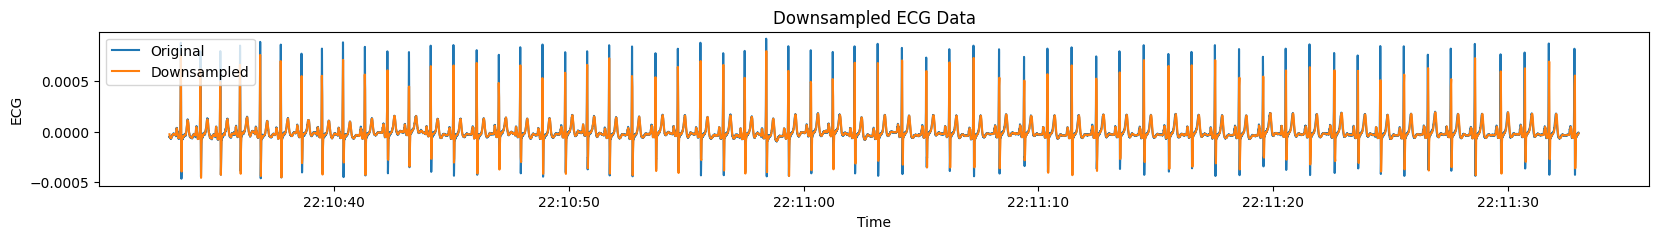

In [25]:
# Plot the original dataset
plt.plot(psg_date_segment.index, psg_date_segment['ECG'], label='Original')
plt.xlabel('Time')
plt.ylabel('ECG')
plt.title('Original ECG Data')
plt.legend()

# Plot the downsampled dataset
plt.plot(psg_resampled.index, psg_resampled['ECG'], label='Downsampled')
plt.xlabel('Time')
plt.ylabel('ECG')
plt.title('Downsampled ECG Data')
plt.legend()

# Show the plots
plt.show()

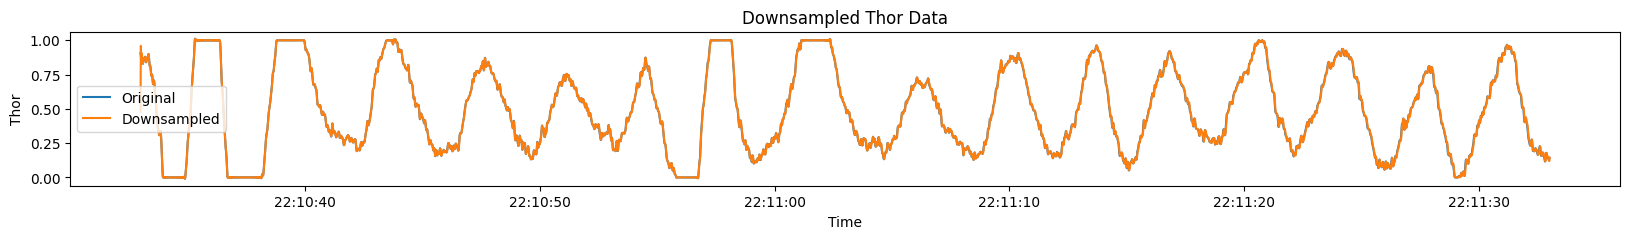

In [26]:
# Plot the original dataset
plt.plot(psg_date_segment.index, psg_date_segment['Thor'], label='Original')
plt.xlabel('Time')
plt.ylabel('Thor')
plt.title('Original Thor Data')
plt.legend()

# Plot the downsampled dataset
plt.plot(psg_resampled.index, psg_resampled['Thor'], label='Downsampled')
plt.xlabel('Time')
plt.ylabel('Thor')
plt.title('Downsampled Thor Data')
plt.legend()

# Show the plots
plt.show()

# Test 4: Resample CW Radar Data

In [27]:
from cw_radar import *
from datetime import datetime


# Example usage of CWDataProcessor
file_path = "/opt/data/private/ZhouWenren/SleepLab/cw_radar/radar20240620220948433561.csv"
radar_sample_rate = 1002

# Create an instance of the CWDataProcessor
cw_processor = CWDataProcessor(file_path, radar_sample_rate)

# Load the data from the specified file
cw_processor.load_data()

Start time: 220948
Sample rate: 1002 Hz


In [28]:
data_subset = extract_data_subset(cw_processor.data, start_datetime, end_datetime)


In [112]:
processed_sig = cw_processor.process_signal(data_subset)
radar_resampled = resample_data(processed_sig, original_freq=radar_sample_rate, target_freq=64)
radar_resampled


,processed_signal
2024-06-20 22:10:33.001129000,0.199088
2024-06-20 22:10:33.016098450,0.406017
2024-06-20 22:10:33.031067901,0.357476
2024-06-20 22:10:33.046037351,0.384347
2024-06-20 22:10:33.061006802,0.368469
...,...
2024-06-20 22:11:32.938809197,-0.093254
2024-06-20 22:11:32.953778648,-0.098249
2024-06-20 22:11:32.968748098,-0.095516
2024-06-20 22:11:32.983717549,-0.104263


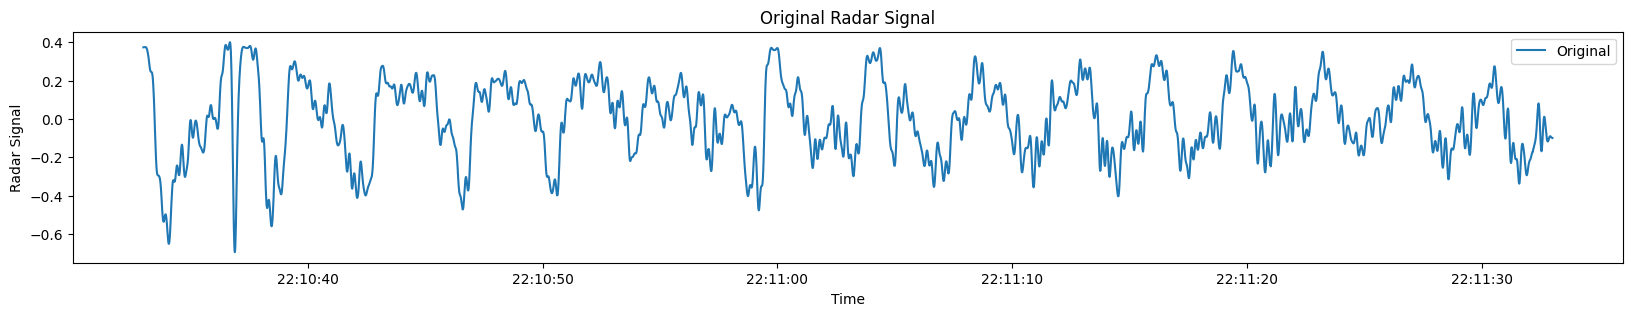

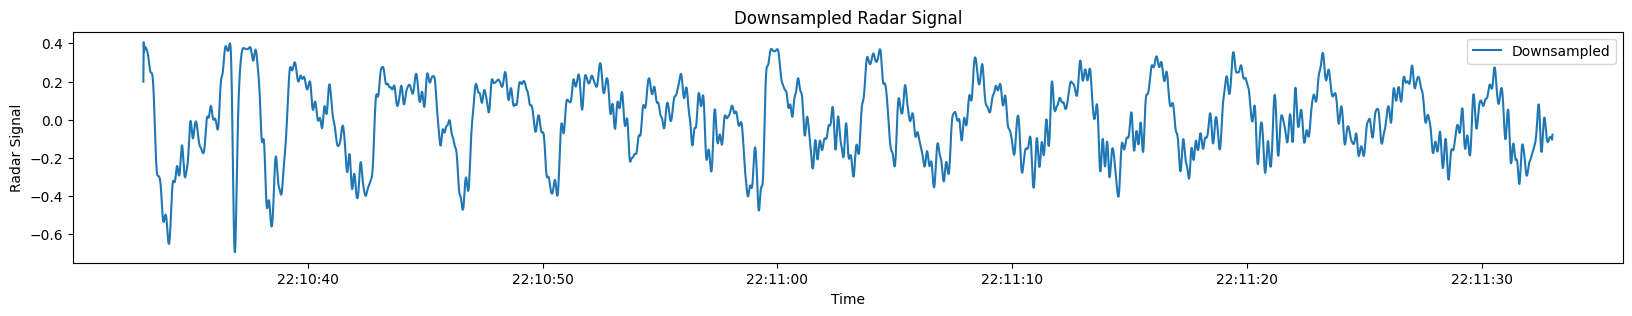

In [113]:
# Plot the original dataset
plt.figure(figsize=(20, 3))
plt.plot(processed_sig, label='Original')
plt.xlabel('Time')
plt.ylabel('Radar Signal')
plt.title('Original Radar Signal')
plt.legend()

# Plot the downsampled dataset
plt.figure(figsize=(20, 3))
plt.plot(radar_resampled, label='Downsampled')
plt.xlabel('Time')
plt.ylabel('Radar Signal')
plt.title('Downsampled Radar Signal')
plt.legend()

# Show the plots
plt.show()

In [114]:
import scipy.signal as signal

def lowpass_filter(fs, sig, highcut, order=4):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='lowpass')
    filtered_signal = signal.filtfilt(b, a, sig)
    return filtered_signal

temp = lowpass_filter(radar_sample_rate, radar_resampled['processed_signal'], 10, order=4)

df_temp = radar_resampled.copy()
df_temp['processed_signal'] = temp

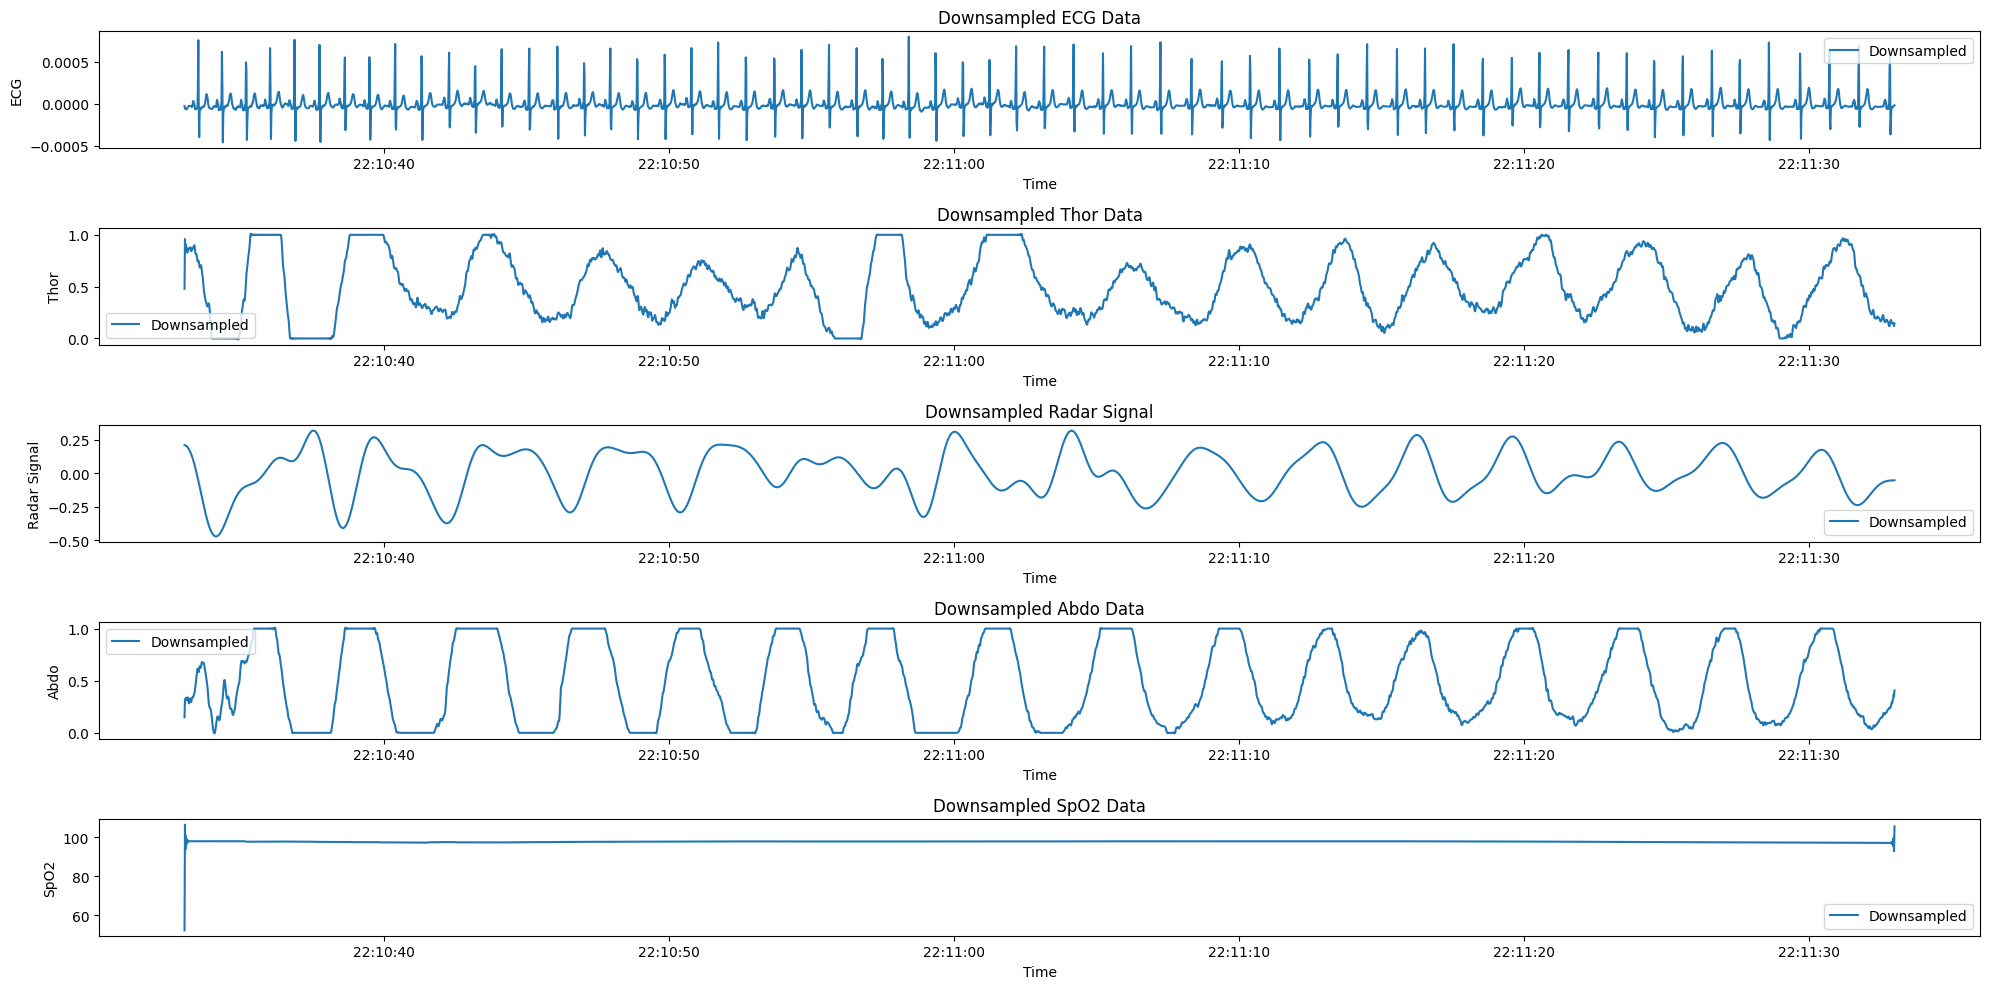

In [117]:
# Create a figure and three subplots vertically
fig, axs = plt.subplots(5, 1, figsize=(20, 10))

# Plot the downsampled ECG data
axs[0].plot(psg_resampled.index, psg_resampled['ECG'], label='Downsampled')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('ECG')
axs[0].set_title('Downsampled ECG Data')
axs[0].legend()

# Plot the downsampled Thor data
axs[1].plot(psg_resampled.index, psg_resampled['Thor'], label='Downsampled')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Thor')
axs[1].set_title('Downsampled Thor Data')
axs[1].legend()

# Plot the downsampled ECG data again
axs[2].plot(radar_resampled.index, temp, label='Downsampled')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Radar Signal')
axs[2].set_title('Downsampled Radar Signal')
axs[2].legend()

# Plot the downsampled Abdo data
axs[3].plot(psg_resampled.index, psg_resampled['Abdo'], label='Downsampled')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Abdo')
axs[3].set_title('Downsampled Abdo Data')
axs[3].legend()

# Plot the downsampled SpO2 data
axs[4].plot(psg_resampled.index, psg_resampled['SpO2'], label='Downsampled')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('SpO2')
axs[4].set_title('Downsampled SpO2 Data')
axs[4].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [118]:
print(psg_date_segment)
print(data_subset)

                                 ECG      Thor      Abdo       SpO2
Time                                                               
2024-06-20 22:10:33.000000 -0.000051  0.906569  0.282216  98.019379
2024-06-20 22:10:33.000977 -0.000050  0.904972  0.282127  98.019581
2024-06-20 22:10:33.001953 -0.000049  0.903318  0.282173  98.019777
2024-06-20 22:10:33.002930 -0.000049  0.901616  0.282352  98.019964
2024-06-20 22:10:33.003906 -0.000050  0.899877  0.282661  98.020141
...                              ...       ...       ...        ...
2024-06-20 22:11:32.995117 -0.000009  0.138765  0.378099  97.164006
2024-06-20 22:11:32.996094 -0.000010  0.139289  0.378615  97.163888
2024-06-20 22:11:32.997070 -0.000012  0.139786  0.379144  97.163762
2024-06-20 22:11:32.998047 -0.000015  0.140255  0.379681  97.163629
2024-06-20 22:11:32.999023 -0.000017  0.140694  0.380226  97.163491

[61440 rows x 4 columns]
                        timestamp  data_i  data_q
44657  2024-06-20 22:10:33.001129  -0.04

In [119]:
print(psg_resampled)
print(radar_resampled)

                                    ECG      Thor      Abdo        SpO2
2024-06-20 22:10:33.000000000 -0.000026  0.478960  0.149699   52.075218
2024-06-20 22:10:33.015628815 -0.000058  0.959280  0.319222  106.579285
2024-06-20 22:10:33.031257631 -0.000055  0.830546  0.307320   93.731723
2024-06-20 22:10:33.046886446 -0.000062  0.907136  0.336300  100.670777
2024-06-20 22:10:33.062515262 -0.000067  0.870757  0.315331   96.376190
...                                 ...       ...       ...         ...
2024-06-20 22:11:32.936507737 -0.000037  0.151029  0.310580   98.263416
2024-06-20 22:11:32.952136553 -0.000028  0.139838  0.327900   95.534508
2024-06-20 22:11:32.967765368 -0.000029  0.133902  0.370358   99.791950
2024-06-20 22:11:32.983394184 -0.000023  0.118988  0.353897   92.913135
2024-06-20 22:11:32.999023000 -0.000018  0.144451  0.407154  105.648035

[3840 rows x 4 columns]
                               processed_signal
2024-06-20 22:10:33.001129000          0.199088
2024-06-20 22:1

In [120]:
temp2 = psg_resampled.drop(columns=['ECG', 'Abdo', 'SpO2'])
temp3 = radar_resampled

# Define a common time grid (using the minimum and maximum timestamps)
common_time_index = pd.date_range(
    start=max(temp2.index.min(), temp3.index.min()), 
    end=min(temp2.index.max(), temp3.index.max()), 
    freq='15.625ms'  # Adjust frequency as necessary, here it matches 64Hz
)

# Reindex and interpolate both dataframes to this common time grid
psg_aligned = temp2.reindex(common_time_index, method='nearest')
radar_aligned = temp3.reindex(common_time_index, method='nearest')

# Now psg_aligned and radar_aligned have the same time index and can be compared


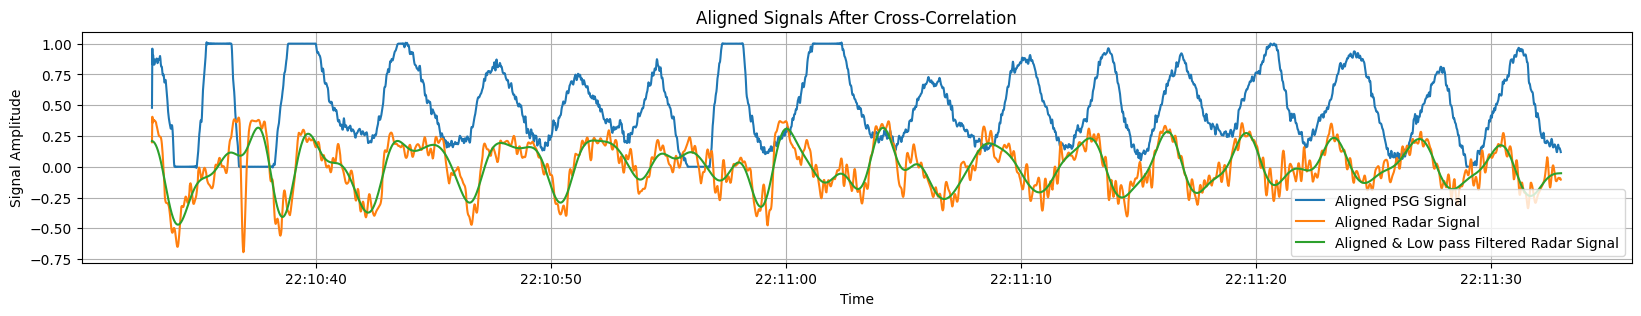

In [125]:
# Plot the aligned signals
plt.figure(figsize=(20, 3))
plt.plot(psg_aligned, label='Aligned PSG Signal')
plt.plot(radar_aligned, label='Aligned Radar Signal')
plt.plot(df_temp, label='Aligned & Low pass Filtered Radar Signal')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.title('Aligned Signals After Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()


Time shift applied: -24.796875 seconds


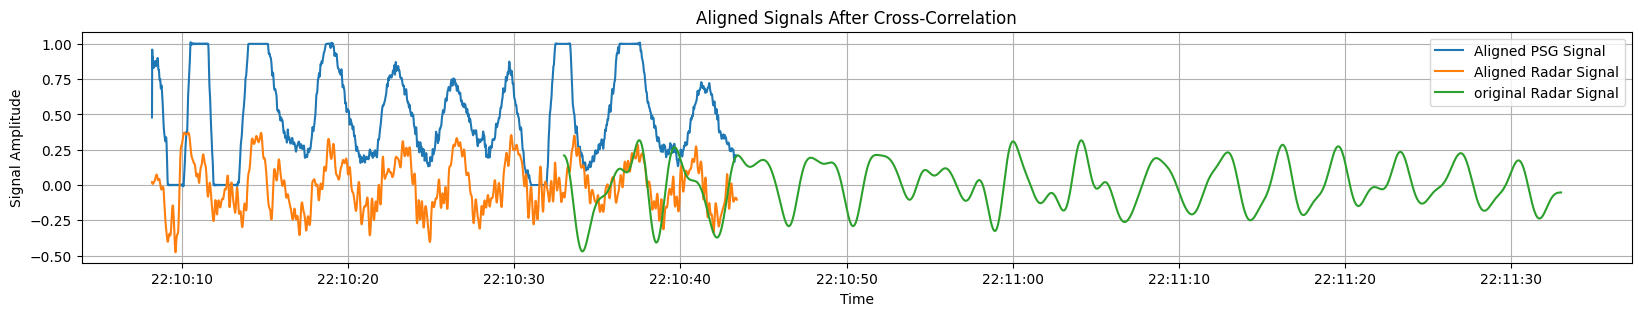

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def cross_correlation_time_alignment(signal1, signal2, sample_rate):
    """
    Aligns two signals by calculating the cross-correlation and shifting one signal to match the other.

    Parameters:
    - signal1, signal2: Pandas Series with timestamps as index.
    - sample_rate: The sample rate of the signals (in Hz).

    Returns:
    - aligned_signal1, aligned_signal2: Aligned signals as Pandas Series.
    """
    # Ensure both signals have the same length
    min_length = min(len(signal1), len(signal2))
    signal1 = signal1.iloc[:min_length]
    signal2 = signal2.iloc[:min_length]

    # Calculate cross-correlation
    correlation = np.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    lag = np.argmax(correlation) - (len(signal1) - 1)
    
    # Convert lag to time
    time_shift = lag / sample_rate
    
    # Shift signal1 or signal2 based on the calculated time lag
    if lag > 0:
        aligned_signal1 = signal1.iloc[lag:].reset_index(drop=True)
        aligned_signal2 = signal2.iloc[:-lag].reset_index(drop=True)
    else:
        aligned_signal1 = signal1.iloc[:lag].reset_index(drop=True)
        aligned_signal2 = signal2.iloc[-lag:].reset_index(drop=True)
    
    # Create a common time index for the aligned signals
    common_time_index = pd.date_range(
        start=signal1.index[0] + pd.to_timedelta(time_shift, unit='s'), 
        periods=len(aligned_signal1), 
        freq=f'{1000 / sample_rate}ms'
    )
    
    aligned_signal1.index = common_time_index
    aligned_signal2.index = common_time_index
    
    return aligned_signal1, aligned_signal2, time_shift

# Example usage:
# Assuming 'psg_resampled' and 'radar_resampled' are your Pandas Series with the same time index
psg_signal = psg_aligned['Thor']  # Replace with your actual signal column
radar_signal = radar_aligned['processed_signal']  # Replace with your actual signal column

aligned_psg_signal, aligned_radar_signal, time_shift = cross_correlation_time_alignment(
    psg_signal, radar_signal, sample_rate=64  # Replace 64 with your actual sample rate
)

print(f"Time shift applied: {time_shift} seconds")

# Plot the aligned signals
plt.figure(figsize=(20, 3))
plt.plot(aligned_psg_signal, label='Aligned PSG Signal')
plt.plot(aligned_radar_signal, label='Aligned Radar Signal')
# plt.plot(radar_aligned, label='Aligned Radar Signal')
plt.plot(df_temp, label='original Radar Signal')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.title('Aligned Signals After Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()
